In [15]:
import math
import colorcet as cc
import holoviews as hv
import hvplot.polars  # noqa
import bokeh
from scipy import stats
# from sklearn import linear_model
import seaborn as sns
import matplotlib.pyplot as plt
from lib import *

# from autogluon.tabular import TabularDataset, TabularPredictor

import polars as pl

pl.Config(tbl_rows=20, fmt_str_lengths=36);

# from selenium import webdriver
# from selenium.webdriver.firefox.service import Service as FirefoxService
# from webdriver_manager.firefox import GeckoDriverManager
# driver = webdriver.Firefox(service=FirefoxService(GeckoDriverManager().install()))

## Runtime basline experiment

**Objective**: Determine if the runtime across distribution types is the same.

In [2]:
df = load_dataset('runtime-baseline')
df = process_runtime_dataset(df)
df.head(5)

dataset_id,run_id,seed,transmission_rate,send_coefficient,tolerance,time_buffer,score_expiry,contact_expiry,flush_timeout,idle_timeout,network_source,network_type,n_nodes,n_edges,contact_time_dist,score_source,score_value_dist,score_time_dist,msg_runtime,total_runtime
str,str,i64,f64,f64,f64,i64,i64,i64,f64,f64,str,str,i64,i64,str,str,str,str,i64,i64
"""864344b9-0add-4685-a522-7197ef37b5c2""","""2""",12345,0.8,1.0,0.0,172800000,1209600000,1209600000,3.0,60.0,"""9d438b7e-39ec-4cd1-a826-8419e38cae02""","""WattsStrogatz""",10000,100000,"""Uniform""","""f063a854-4769-4c4e-b375-05ad4c31c3c2""","""Normal""","""Normal""",15158,66475
"""864344b9-0add-4685-a522-7197ef37b5c2""","""3""",12345,0.8,1.0,0.0,172800000,1209600000,1209600000,3.0,60.0,"""96ad1ea6-1cff-40a3-9281-8077c061e2b4""","""WattsStrogatz""",10000,100000,"""Uniform""","""d5779194-7303-46ed-a310-94d5487e55d4""","""Normal""","""Normal""",15127,66369
"""864344b9-0add-4685-a522-7197ef37b5c2""","""4""",12345,0.8,1.0,0.0,172800000,1209600000,1209600000,3.0,60.0,"""1c4bd1b1-5f38-4196-b060-3418415408d1""","""WattsStrogatz""",10000,100000,"""Uniform""","""3cfc6edd-13a5-4103-afff-d478d4d06db8""","""Normal""","""Normal""",12113,66294
"""864344b9-0add-4685-a522-7197ef37b5c2""","""5""",12345,0.8,1.0,0.0,172800000,1209600000,1209600000,3.0,60.0,"""f393d1e8-243d-40b9-ad72-4e3cd7abc0d9""","""WattsStrogatz""",10000,100000,"""Uniform""","""c93817e7-2201-4655-bbab-5bc7d2250156""","""Normal""","""Normal""",12123,66311
"""864344b9-0add-4685-a522-7197ef37b5c2""","""6""",12345,0.8,1.0,0.0,172800000,1209600000,1209600000,3.0,60.0,"""cdf6c328-ff16-49ba-815e-5a970548228c""","""WattsStrogatz""",10000,100000,"""Uniform""","""c7e98445-224e-4a14-bb67-87b7898eeee7""","""Normal""","""Normal""",12126,66394


In [3]:
df.height

160

In [4]:
get_runtimes(df, by_distributions=True).shape

(8, 20)

ANOVA assumes normality. Use the Shapiro-Wilks test.

https://en.wikipedia.org/wiki/Analysis_of_variance#Assumptions

https://www.pythonfordatascience.org/parametric-assumptions-python

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html#scipy.stats.shapiro

In [5]:
apply_hypothesis_test(df, stats.shapiro, by_distributions=True)

ShapiroResult(statistic=0.67198017890183, pvalue=2.042930122606384e-17)

In [7]:
apply_hypothesis_test(df, stats.shapiro, by_network_type=True)

{'BarabasiAlbert': ShapiroResult(statistic=0.6455841858114167, pvalue=1.3871243031399214e-08),
 'GnmRandom': ShapiroResult(statistic=0.4722427270825328, pvalue=8.131432237889303e-11),
 'RandomRegular': ShapiroResult(statistic=0.5834436164177577, pvalue=1.872371357241357e-09),
 'WattsStrogatz': ShapiroResult(statistic=0.43728166802888524, pvalue=3.332332165092599e-11)}

The $p$ values are very low, which suggests the null hypothesis of normality is rejected.

To use non-parametric ANOVA, we must still ensure the homoscedasticity assumption holds.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.fligner.html

In [8]:
apply_hypothesis_test(df, stats.fligner, by_distributions=True)

FlignerResult(statistic=2.2556518288003913, pvalue=0.9443471249508537)

The $p$ value is high, which indicates the null hypothesis of homoscedasticity cannot be rejected.

The Kruskal-Wallis test is the non-parametric equivalent of one-way ANOVA.

https://en.wikipedia.org/wiki/Kruskal–Wallis_test

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kruskal.html#scipy.stats.kruskal

In [9]:
apply_hypothesis_test(df, stats.kruskal, by_distributions=True)

KruskalResult(statistic=7.030418187414842, pvalue=0.4257196188778194)

In [10]:
apply_hypothesis_test(df, stats.kruskal, by_network_type=True)

{'BarabasiAlbert': KruskalResult(statistic=39.00000000000002, pvalue=0.4698781977712059),
 'GnmRandom': KruskalResult(statistic=39.00000000000001, pvalue=0.46987819777120615),
 'RandomRegular': KruskalResult(statistic=39.00000000000001, pvalue=0.46987819777120615),
 'WattsStrogatz': KruskalResult(statistic=39.00000000000002, pvalue=0.4698781977712059)}

A high $p$ value indicates that the null hypothesis cannot be rejected.

**Conclusion:** There is no statistically significant difference in runtime across data distributions.

## Runtime experiment

In [2]:
df = load_dataset('runtime')
df = process_runtime_dataset(df)
df.head(5)

id,key,network_id,network_type,n_nodes,n_edges,ct_random_type,sv_random_type,st_random_type,send_coefficient,tolerance,msg_runtime,total_runtime
str,str,str,str,i64,i64,str,str,str,f64,f64,i64,i64
"""1bf9a375-f230-4599-a64f-334404…","""2""","""947ed9d5-1119-41d4-bd63-2a573c…","""GnmRandom""",40000,3000000,"""Uniform""","""Uniform""","""Uniform""",1.0,0.0,12714,72063
"""1bf9a375-f230-4599-a64f-334404…","""3""","""060c0aad-4b4e-4369-b01b-d08b8e…","""GnmRandom""",40000,3000000,"""Uniform""","""Uniform""","""Uniform""",1.0,0.0,18017,73006
"""1bf9a375-f230-4599-a64f-334404…","""4""","""723d53dd-4539-41b4-9c45-783fcf…","""GnmRandom""",40000,3000000,"""Uniform""","""Uniform""","""Uniform""",1.0,0.0,13678,71712
"""1bf9a375-f230-4599-a64f-334404…","""5""","""88547a58-edd0-4710-bb91-034578…","""GnmRandom""",40000,3000000,"""Uniform""","""Uniform""","""Uniform""",1.0,0.0,14364,72129
"""1bf9a375-f230-4599-a64f-334404…","""6""","""386f9f45-b551-469a-a36f-8fd225…","""GnmRandom""",40000,3000000,"""Uniform""","""Uniform""","""Uniform""",1.0,0.0,29234,-1


In [10]:
dataset = df.select("n_nodes", "n_edges", "msg_runtime").sample(shuffle=True, seed=12345)
x = dataset.select("n_nodes", "n_edges")
y = dataset.select("msg_runtime")
train_fraction = 0.66
test_fraction = 1 - train_fraction
n_train = math.floor(dataset.height * 0.66)
n_test = dataset.height - n_train
x_train = x.head(n_train)
y_train = x.head(n_train)
x_test = x.tail(-n_train)
y_test = y.tail(-n_train)

In [ ]:
dataset.select('

In [58]:
df = df.with_columns(
    density=2 * pl.col('n_edges') / (pl.col('n_nodes') ** 2 - pl.col('n_nodes')),
    mean_degree=2 * pl.col('n_edges') / pl.col('n_nodes')
)

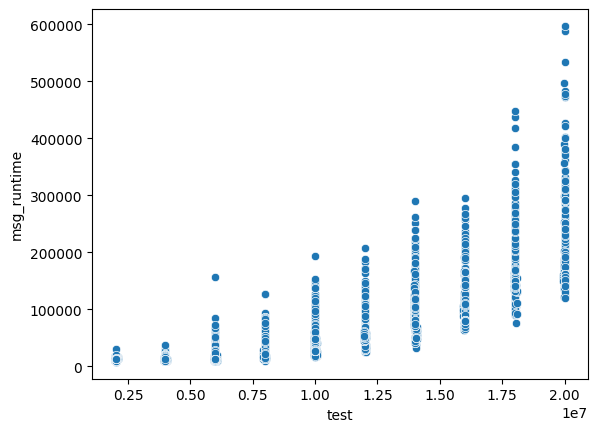

In [69]:
sns.scatterplot(df.with_columns((pl.col('n_nodes') * pl.col('mean_degree')).alias('test')), x='test', y='msg_runtime');

In [104]:
rendered = hv.render(
    df
    .filter(pl.col('network_type').eq('BarabasiAlbert'))
    .plot.scatter(x='n_edges', y='msg_runtime', color='network_type')
)
bokeh.io.export_svg(rendered, filename='test.svg', webdriver=driver)

['test.svg']

## Send coefficient experiment

In [40]:
df = load_dataset('send-coefficient')
df = process_parameter_dataset(df)
df.head(3)

dataset_id,run_id,seed,transmission_rate,send_coefficient,tolerance,time_buffer,score_expiry,contact_expiry,flush_timeout,idle_timeout,network_source,network_type,n_nodes,n_edges,contact_time_dist,score_source,score_value_dist,score_time_dist,n_influenced,n_influences,msg_reachability,msg_runtime,total_runtime,score_diff,exposure_score,n_receives,n_updates,n_contacts,user_id
str,str,i64,f64,f64,f64,i64,i64,i64,f64,f64,str,str,i64,i64,str,str,str,str,i64,i64,i64,i64,i64,f64,f64,i64,i64,i64,i64
"""025aa793-7966-4e9a-be77-8fc598315dad""","""1""",12345,0.8,0.8,0.0,172800000,1209600000,1209600000,3.0,60.0,"""bad7046e-3a9d-4df0-91cf-86b551cf1290""","""GnmRandom""",5000,50000,"""Uniform""","""7a673714-5b94-4e7c-a026-85068fd52f97""","""Uniform""","""Uniform""",0,36,0,27349,67019,0.247281,0.61155,69,3,16,0
"""025aa793-7966-4e9a-be77-8fc598315dad""","""1""",12345,0.8,0.8,0.0,172800000,1209600000,1209600000,3.0,60.0,"""bad7046e-3a9d-4df0-91cf-86b551cf1290""","""GnmRandom""",5000,50000,"""Uniform""","""7a673714-5b94-4e7c-a026-85068fd52f97""","""Uniform""","""Uniform""",141,50,3,27349,67019,0.18217,0.764438,105,2,29,1
"""025aa793-7966-4e9a-be77-8fc598315dad""","""1""",12345,0.8,0.8,0.0,172800000,1209600000,1209600000,3.0,60.0,"""bad7046e-3a9d-4df0-91cf-86b551cf1290""","""GnmRandom""",5000,50000,"""Uniform""","""7a673714-5b94-4e7c-a026-85068fd52f97""","""Uniform""","""Uniform""",4,40,1,27349,67019,0.0,0.885256,79,1,19,2


- **Independent variables:** network_type, ct_random_type, sv_random_type, st_random_type, send_coefficient, tolerance
- **Dependent variables:**
  - **Efficiency:** n_influenced, n_influences, msg_reachability, n_receives
  - **Accuracy:** exposure_diff, exposure_score
  - n_updates does not matter for efficiency or accuracy. Regarding the former, n_receives is the metric of interest. As for the latter, the global ordering of the messages received is assumed to be nondeterministic. We care about the end state, not how many updates it took to get there.

In [50]:
results = compute_accuracy_results(
    df,
    parameter='send_coefficient', 
    by_network_type=True,
    by_distribution_type=True,
    percentiles=[0, 0.01, 0.1, *range(1, 7)]
)

In [56]:
accuracy = results.tabular.select(
    'dataset_id',
    'run_id',
    'network_source',
    'score_source',
    'user_id',
    'send_coefficient',
    'network_type',
    'contact_time_dist',
    'score_value_dist',
    'score_time_dist',
    'accuracy'
)

In [76]:
parameter = 'send_coefficient'
axes = [parameter, 'network_type']

(
    accuracy
    .group_by(axes)
    .agg(pl.col('accuracy').quantile(0.05, interpolation='midpoint'))
    .sort(axes)
)

send_coefficient,network_type,accuracy
f64,str,f64
0.8,"""BarabasiAlbert""",0.903648
0.8,"""GnmRandom""",0.9223
0.8,"""RandomRegular""",0.924744
0.8,"""WattsStrogatz""",0.966184
0.9,"""BarabasiAlbert""",0.991293
0.9,"""GnmRandom""",1.0
0.9,"""RandomRegular""",1.0
0.9,"""WattsStrogatz""",1.0
1.0,"""BarabasiAlbert""",1.0


(0.92, 1.0)

/Users/rtatton/Library/Caches/pypoetry/virtualenvs/evaluation-pIWKJ1Ba-py3.11/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/rtatton/Library/Caches/pypoetry/virtualenvs/evaluation-pIWKJ1Ba-py3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


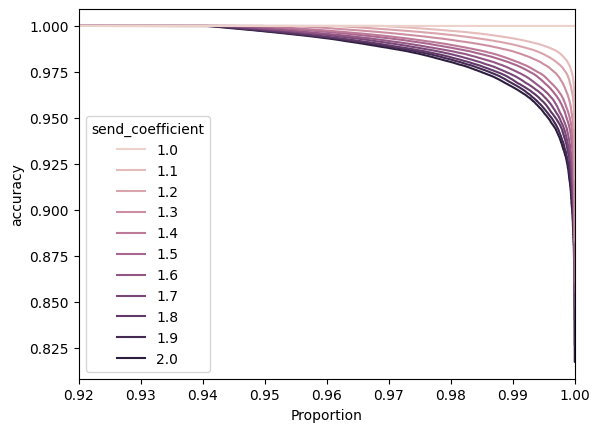

In [81]:
ax = sns.ecdfplot(accuracy.filter(pl.col('send_coefficient') > 0.9), y='accuracy', hue='send_coefficient', complementary=True);
ax.set_xlim(0.92)

In [ ]:
accuracy_nt = compute_accuracy_results(
    df, 
    parameter='send_coefficient', 
    percentiles=[0, 0.01, 0.1, *range(1, 12)],
    by_network_type=True
)
accuracy_nt

In [4]:
melted = (
    accuracy
    .drop('network_type', 'frequency', 'normalized_frequency')
    .melt(id_vars=['send_coefficient'], variable_name='percentile', value_name='accuracy')
    .with_columns(pl.col('percentile').str.strip_prefix("accuracy_p").cast(pl.Float64))
)

In [ ]:
melted

In [18]:
box = melted.hvplot.box(by='percentile', y='accuracy', box_fill_alpha=0)

scatter = melted.hvplot.scatter(
    x='percentile',
    y='accuracy',
    c='send_coefficient',
    cmap=cc.b_linear_kry_5_98_c75,
    clabel='Send coefficient',
    size=10
).opts(jitter=0.0)

plot = (box * scatter).opts(
    show_legend=False,
    xlabel='Percentile',
    ylabel='Accuracy',
    backend_opts={"plot.toolbar.autohide": True}
)

# io.export_png(hv.render(plot), filename='accuracy-box.png', webdriver=driver)

In [19]:
plot

:Overlay
   .BoxWhisker.I :BoxWhisker   [percentile]   (accuracy)
   .Scatter.I    :Scatter   [percentile]   (accuracy,send_coefficient)

In [5]:
results = compute_efficiency_results(df, parameter='send_coefficient', by_network_type=True)
# results.hvplot.box(y='n_updates', by='send_coefficient')
# results.hvplot.scatter(y='n_updates', x='send_coefficient', by='network_type')

In [15]:
results = compute_efficiency_results(df, parameter='send_coefficient', normalize=True, min_parameter_value=1, aggregate=True)
# results.hvplot.scatter(y='n_receives', x='send_coefficient')

In [16]:
results

send_coefficient,n_receives_p0,n_receives_p10,n_receives_p25,n_receives_p50,n_receives_p75,n_receives_p90,n_receives_p100
f64,f64,f64,f64,f64,f64,f64,f64
1.1,0.824876,0.856025,0.871544,0.883133,0.892955,0.902124,0.932682
1.2,0.789661,0.814953,0.825747,0.836256,0.845765,0.851263,0.874743
1.3,0.768065,0.784393,0.794866,0.802582,0.809542,0.814189,0.834751
1.4,0.734265,0.761263,0.770824,0.779254,0.788753,0.79684,0.807532
1.5,0.721004,0.748131,0.75746,0.765214,0.773415,0.780967,0.793108
1.6,0.712866,0.734713,0.745236,0.754542,0.762763,0.77063,0.788188
1.7,0.710734,0.727848,0.737405,0.746412,0.754647,0.76349,0.776893
1.8,0.702677,0.718212,0.727209,0.740016,0.749499,0.756821,0.767154
1.9,0.694792,0.714731,0.721981,0.735757,0.744919,0.752384,0.761624


In [22]:
kwargs = {'normalize': True, 'min_parameter_value': 0}

efficiency = compute_efficiency_results(df, parameter='send_coefficient', **kwargs)
efficiency_nt = compute_efficiency_results(df, parameter='send_coefficient', by_network_type=True, **kwargs)

In [25]:
def percentiles(df, metric, percentiles=(0, 10, 25, 50, 75, 90, 95, 99, 100),
                group_by=('network_type', 'send_coefficient')):
    return (
        df
        .group_by(*group_by)
        .agg(**{f'$$P_{ {p} }$$': pl.col(metric).quantile(p / 100) for p in percentiles})
        .sort(group_by)
    )

In [26]:
percentiles(df, 'msg_reachability', group_by=('network_type', 'tolerance'))

network_type,tolerance,$$P_{0}$$,$$P_{10}$$,$$P_{25}$$,$$P_{50}$$,$$P_{75}$$,$$P_{90}$$,$$P_{95}$$,$$P_{99}$$,$$P_{100}$$
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""BarabasiAlbert""",0.0,0.0,0.0,0.0,1.0,1.0,2.0,3.0,4.0,9.0
"""GnmRandom""",0.0,0.0,0.0,0.0,1.0,2.0,2.0,3.0,4.0,9.0
"""RandomRegular""",0.0,0.0,0.0,0.0,1.0,2.0,2.0,3.0,4.0,9.0
"""WattsStrogatz""",0.0,0.0,0.0,0.0,1.0,2.0,3.0,3.0,5.0,12.0


In [27]:
percentiles(df, 'msg_reachability', group_by=['network_type'])

network_type,$$P_{0}$$,$$P_{10}$$,$$P_{25}$$,$$P_{50}$$,$$P_{75}$$,$$P_{90}$$,$$P_{95}$$,$$P_{99}$$,$$P_{100}$$
str,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""BarabasiAlbert""",0.0,0.0,0.0,1.0,1.0,2.0,3.0,4.0,9.0
"""GnmRandom""",0.0,0.0,0.0,1.0,2.0,2.0,3.0,4.0,9.0
"""RandomRegular""",0.0,0.0,0.0,1.0,2.0,2.0,3.0,4.0,9.0
"""WattsStrogatz""",0.0,0.0,0.0,1.0,2.0,3.0,3.0,5.0,12.0


In [28]:
percentiles(df, 'msg_reachability', group_by=['tolerance'])

tolerance,$$P_{0}$$,$$P_{10}$$,$$P_{25}$$,$$P_{50}$$,$$P_{75}$$,$$P_{90}$$,$$P_{95}$$,$$P_{99}$$,$$P_{100}$$
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.0,0.0,0.0,0.0,1.0,2.0,2.0,3.0,4.0,12.0


In [29]:
percentiles(df, 'n_influenced')

network_type,send_coefficient,$$P_{0}$$,$$P_{10}$$,$$P_{25}$$,$$P_{50}$$,$$P_{75}$$,$$P_{90}$$,$$P_{95}$$,$$P_{99}$$,$$P_{100}$$
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""BarabasiAlbert""",0.8,0.0,0.0,0.0,0.0,0.0,38.0,141.0,784.0,4999.0
"""BarabasiAlbert""",0.9,0.0,0.0,0.0,0.0,5.0,54.0,165.0,562.0,4980.0
"""BarabasiAlbert""",1.0,0.0,0.0,0.0,0.0,9.0,48.0,110.0,466.0,3910.0
"""BarabasiAlbert""",1.1,0.0,0.0,0.0,0.0,10.0,40.0,90.0,379.0,4082.0
"""BarabasiAlbert""",1.2,0.0,0.0,0.0,0.0,11.0,37.0,81.0,357.0,3960.0
"""BarabasiAlbert""",1.3,0.0,0.0,0.0,1.0,11.0,34.0,73.0,339.0,4478.0
"""BarabasiAlbert""",1.4,0.0,0.0,0.0,3.0,11.0,32.0,67.0,314.0,4200.0
"""BarabasiAlbert""",1.5,0.0,0.0,0.0,4.0,12.0,31.0,66.0,303.0,4190.0
"""BarabasiAlbert""",1.6,0.0,0.0,0.0,4.0,12.0,31.0,65.0,297.0,4175.0


In [30]:
percentiles(df, 'n_influenced', group_by=['network_type'])

network_type,$$P_{0}$$,$$P_{10}$$,$$P_{25}$$,$$P_{50}$$,$$P_{75}$$,$$P_{90}$$,$$P_{95}$$,$$P_{99}$$,$$P_{100}$$
str,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""BarabasiAlbert""",0.0,0.0,0.0,1.0,11.0,34.0,80.0,387.0,4999.0
"""GnmRandom""",0.0,0.0,0.0,4.0,17.0,49.0,103.0,361.0,4999.0
"""RandomRegular""",0.0,0.0,0.0,4.0,18.0,50.0,104.0,359.0,4999.0
"""WattsStrogatz""",0.0,0.0,0.0,8.0,20.0,48.0,82.0,239.0,4998.0


In [31]:
percentiles(df, 'n_influenced', group_by=['tolerance'])

tolerance,$$P_{0}$$,$$P_{10}$$,$$P_{25}$$,$$P_{50}$$,$$P_{75}$$,$$P_{90}$$,$$P_{95}$$,$$P_{99}$$,$$P_{100}$$
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.0,0.0,0.0,0.0,4.0,17.0,45.0,92.0,334.0,4999.0


In [ ]:
percentiles(df, 'n_influences')

In [ ]:
percentiles(df, 'n_influences', group_by=['network_type'])

In [ ]:
percentiles(df, 'n_influences', group_by=['send_coefficient'])

In [32]:
(
    df
    .filter(pl.col.network_type == 'BarabasiAlbert')
    .hvplot.hist(y='msg_reachability', by='send_coefficient', subplots=True, width=250, height=250, xlim=(-0.5, 7.5),
                 shared_axes=False)
    .cols(3)
)

:NdLayout   [send_coefficient]
   :Histogram   [msg_reachability]   (Count)

In [33]:
(
    df
    .filter(pl.col.network_type == 'RandomRegular')
    .hvplot.hist(y='msg_reachability', by='send_coefficient', subplots=True, width=250, height=250, xlim=(-0.5, 7.5),
                 shared_axes=False)
    .cols(3)
)

:NdLayout   [send_coefficient]
   :Histogram   [msg_reachability]   (Count)

In [20]:
(
    df
    .filter(pl.col.network_type == 'GnmRandom')
    .hvplot.hist(y='msg_reachability', by='send_coefficient', subplots=True, width=250, height=250, xlim=(-0.5, 7.5),
                 shared_axes=False)
    .cols(3)
)

:NdLayout   [send_coefficient]
   :Histogram   [msg_reachability]   (Count)

In [ ]:
(
    df
    .filter(pl.col.network_type == 'WattsStrogatz')
    .hvplot.hist(y='msg_reachability', by='send_coefficient', subplots=True, width=250, height=250, xlim=(-0.5, 7.5),
                 shared_axes=False)
    .cols(3)
)

In [29]:
(
    df
    .hvplot.hist(y='msg_reachability', by='send_coefficient', subplots=True, width=250, height=250, xlim=(-0.5, 7.5),
                 shared_axes=False)
    .cols(3)
)

:NdLayout   [send_coefficient]
   :Histogram   [msg_reachability]   (msg_reachability_count)

In [34]:
(
    df
    .hvplot.kde(
        y='n_influenced',
        by='send_coefficient',
        subplots=True,
        shared_axes=True,
        xlim=(0, 100),
        xlabel='Influence set cardinality',
        ylabel='Density',
        clabel='Network type',
        fill_alpha=0.5,
        height=250,
        width=250,
    ).cols(3)
)

:NdLayout   [send_coefficient]
   :Distribution   [n_influenced]   (Density)

In [18]:
(
    df
    .filter(pl.col.network_type == 'WattsStrogatz')
    .hvplot.kde(
        y='n_influenced',
        by='send_coefficient',
        # subplots=True,
        # shared_axes=False,
        xlim=(0, 100),
        xlabel='Influence set cardinality',
        ylabel='Density',
        clabel='Network type',
        fill_alpha=0.5,
    )
)

:NdOverlay   [send_coefficient]
   :Distribution   [n_influenced]   (Density)

In [17]:
(
    df
    .hvplot.kde(
        y='n_influenced',
        by='network_type',
        xlim=(0, 100),
        xlabel='Influence set cardinality',
        ylabel='Density',
        clabel='Network type',
        color=[cc.CET_CBTL4[int(i)] for i in np.linspace(0, 255, 4)]
    )
)

:NdOverlay   [network_type]
   :Distribution   [n_influenced]   (Density)

In [33]:
(
    df
    .hvplot.kde(
        y='n_influences',
        by='network_type',
        xlim=(0, 100),
        xlabel='Source set cardinality',
        ylabel='Density',
        clabel='Network type',
        color=[cc.CET_CBTL4[int(i)] for i in np.linspace(0, 255, 4)]
    )
)

:NdOverlay   [network_type]
   :Distribution   [n_influences]   (Density)

In [7]:
df = RuntimeDataset.load('runtime')

In [19]:
runtimes = (
    df
    .select('msg_runtime', 'total_runtime')
    .with_columns(runtime_percent=pl.col.msg_runtime / pl.col.total_runtime)
)

In [9]:
df

id,key,network_id,network_type,n_nodes,n_edges,ct_random_type,sv_random_type,st_random_type,send_coefficient,tolerance,msg_runtime,total_runtime
str,str,str,str,i64,i64,str,str,str,f64,f64,i64,i64
"""1bf9a375-f230-4599-a64f-334404…","""1""","""84b256a5-b69e-4372-acfc-645d19…","""GnmRandom""",40000,3000000,"""Uniform""","""Uniform""","""Uniform""",1.0,0.0,45450,107022
"""1bf9a375-f230-4599-a64f-334404…","""2""","""947ed9d5-1119-41d4-bd63-2a573c…","""GnmRandom""",40000,3000000,"""Uniform""","""Uniform""","""Uniform""",1.0,0.0,12714,72063
"""1bf9a375-f230-4599-a64f-334404…","""3""","""060c0aad-4b4e-4369-b01b-d08b8e…","""GnmRandom""",40000,3000000,"""Uniform""","""Uniform""","""Uniform""",1.0,0.0,18017,73006
"""1bf9a375-f230-4599-a64f-334404…","""4""","""723d53dd-4539-41b4-9c45-783fcf…","""GnmRandom""",40000,3000000,"""Uniform""","""Uniform""","""Uniform""",1.0,0.0,13678,71712
"""1bf9a375-f230-4599-a64f-334404…","""5""","""88547a58-edd0-4710-bb91-034578…","""GnmRandom""",40000,3000000,"""Uniform""","""Uniform""","""Uniform""",1.0,0.0,14364,72129
"""1bf9a375-f230-4599-a64f-334404…","""6""","""386f9f45-b551-469a-a36f-8fd225…","""GnmRandom""",40000,3000000,"""Uniform""","""Uniform""","""Uniform""",1.0,0.0,29234,-1
"""e46e6f27-e7da-44b8-8af6-9f3a81…","""1""","""8579e7d4-e1eb-46cc-afb1-476d86…","""GnmRandom""",70000,5000000,"""Uniform""","""Uniform""","""Uniform""",1.0,0.0,38650,94422
"""e46e6f27-e7da-44b8-8af6-9f3a81…","""2""","""b3ae70f7-43fc-4589-bc8c-417368…","""GnmRandom""",70000,5000000,"""Uniform""","""Uniform""","""Uniform""",1.0,0.0,49075,107077
"""e46e6f27-e7da-44b8-8af6-9f3a81…","""3""","""86813600-78a0-4533-acc5-479cba…","""GnmRandom""",70000,5000000,"""Uniform""","""Uniform""","""Uniform""",1.0,0.0,35029,91951


In [20]:
df.filter(pl.col.n_nodes == 10_000).hvplot.scatter(
    x='n_edges',
    y='msg_runtime',
    groupby='network_type',
    color='n_nodes',
    subplots=True,
    width=500,
    height=250,
    size=5
)

DynamicMap cannot be displayed without explicit indexing as 'network_type' dimension(s) are unbounded. 
Set dimensions bounds with the DynamicMap redim.range or redim.values methods.

:DynamicMap   [network_type]

In [ ]:
data = (
    df
    .select('n_nodes', 'n_edges', 'msg_runtime')
    .collect()
    .to_numpy()
)

x = data[:, :-1]
y = data[:, -1]

In [ ]:
reg = linear_model.Ridge(alpha=20)

In [ ]:
reg.fit(x, y)

In [ ]:
reg.coef_

In [ ]:
nodes = np.arange(1e2, 1e6, 100)
edges = np.arange(1e2, 1e6, 100)

In [ ]:
df = pl.DataFrame({
    'nodes': np.arange(1e2, 1e6, 100),
    'edges': np.arange(1e2, 1e6, 100)
})

In [ ]:
reg.score(x, y)

In [ ]:
df = df.with_columns(runtime=reg.intercept_ + pl.col.nodes * reg.coef_[0] + pl.col.edges * reg.coef_[1])

In [ ]:
df.hvplot.scatter(x='edges', y='runtime')

In [ ]:
import seaborn as sns

In [ ]:
sns.regplot(x=x[:, -1], y=y);

In [ ]:
x